### Cats and Dogs em uma VGG16 pré treinada na ImageNet

In [1]:
# Usando uma rede pre-treinada para avaliar cats and dogs
from keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet',
                include_top = False,
                input_shape = (150,150,3))

# weights: espeficifica o checkpoint de peso que o modelo será inicializado
# include_top: especifica se a camada densamente conectada deve ser inclusa
# input_shape: especifica o formato de entrada. Se não especificado, a rede
# conseguira processar entradas de qualquer tamanho

In [2]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

O feature map final tem formato(4, 4, 512). É neste feature map que vou utilizar a minha rede densa.

Vou passar todas as imagens uma única vez pela rede pré-treinada, e então utilizar a saída como entrada para treinar uma rede densamente conectada.

### Feature Extraction rápida sem Data Augmentation

In [16]:
# Extração rápida de recursos sem data augmentation
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = os.getcwd()
base_dir = os.path.join(base_dir, 'cats_and_dogs_small')

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale = 1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape = (sample_count, 4, 4, 512))
    labels = np.zeros(shape = (sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size = (150,150),
        batch_size = batch_size,
        class_mode = 'binary')
    
    i = 0 
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i+1) * batch_size] = features_batch
        labels[i * batch_size : (i+1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [4]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
1/1 [==============================] - 3s 3s/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 2s 2s/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 3s 3s/step


In [5]:
# As features extraidas estão em formato (samples, 4, 4, 512). Para utiliza-las
# na rede densa é necessário primeiro dar um reshape nos dados para (samples, 8192)

train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [6]:
# Definindo e treinando o classificador densamente conectado
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation = 'relu', input_dim = 4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(optimizer = optimizers.RMSprop(learning_rate = 2e-5),
             loss = 'binary_crossentropy',
             metrics = ['acc'])

history = model.fit(train_features, train_labels,
                   epochs = 30,
                   batch_size = 20,
                   validation_data = (validation_features, validation_labels))


Epoch 1/30
100/100 [==============================] - 7s 52ms/step - loss: 0.5827 - acc: 0.6825 - val_loss: 0.4437 - val_acc: 0.8290
Epoch 2/30
100/100 [==============================] - 5s 50ms/step - loss: 0.4236 - acc: 0.8080 - val_loss: 0.3724 - val_acc: 0.8460
Epoch 3/30
100/100 [==============================] - 5s 49ms/step - loss: 0.3582 - acc: 0.8435 - val_loss: 0.3404 - val_acc: 0.8590
Epoch 4/30
100/100 [==============================] - 5s 51ms/step - loss: 0.3182 - acc: 0.8720 - val_loss: 0.3116 - val_acc: 0.8660
Epoch 5/30
100/100 [==============================] - 5s 50ms/step - loss: 0.2843 - acc: 0.8880 - val_loss: 0.3026 - val_acc: 0.8560
Epoch 6/30
100/100 [==============================] - 5s 51ms/step - loss: 0.2583 - acc: 0.8985 - val_loss: 0.2952 - val_acc: 0.8760
Epoch 7/30
100/100 [==============================] - 5s 50ms/step - loss: 0.2502 - acc: 0.9025 - val_loss: 0.2809 - val_acc: 0.8720
Epoch 8/30
100/100 [==============================] - 5s 50ms/step - 

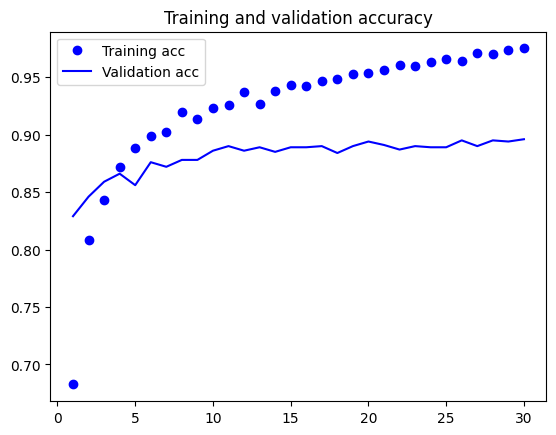

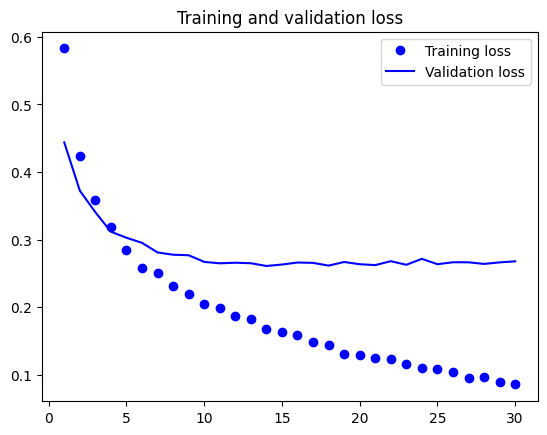

In [7]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [15]:
test_loss, test_acc = model.evaluate(test_features, test_labels, batch_size = 1000)
test_acc

1/1 [==============================] - 0s 141ms/step - loss: 0.2339 - acc: 0.8930


0.8930000066757202